### Bibliotecas utilizadas em todas as celulas

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import talib as ta
from backtesting import Backtest, Strategy
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    mean_absolute_error,
    mean_squared_error,
)
from sklearn.model_selection import cross_val_score, train_test_split

from bot.historico_precos import get_price_history
from bot.logs.config_log import console
from bot.models.coin_pair import CoinPair
from db.duckdb_csv import load_csv_in_dataframe, save_to_csv_duckdb
from segredos import BASE_DIR


c:\Users\joaod\Documents\GitHub\crypto\.venv\Lib\site-packages\backtesting\_plotting.py:54: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

### Definição da única moeda utilizada

In [2]:
coinpair = CoinPair(
    base='BTC',
    quote='BRL',
)

### Primeiro dataset:
 - Entradas: volume, preço de abertura, preço de fechamento, preço máximo e preço mínimo
 - Saida: preço de fechamento deslocado em uma linha

In [3]:
df = get_price_history(coin_pair=coinpair)
df['y'] = df['close'].shift(-1)
df = df.dropna()
save_to_csv_duckdb(
    df,
    BASE_DIR
    + '/datasets'
    + '/saida_como_preco_do_ativo_'
    + f'{coinpair.bitpreco_websocket}_{coinpair.exchange.value}'
    + '.csv',
)

True

1. Análise Exploratória dos Dados

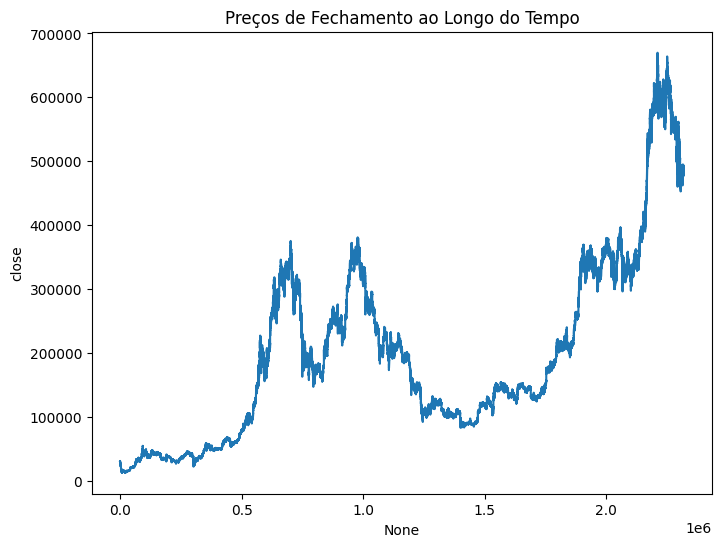

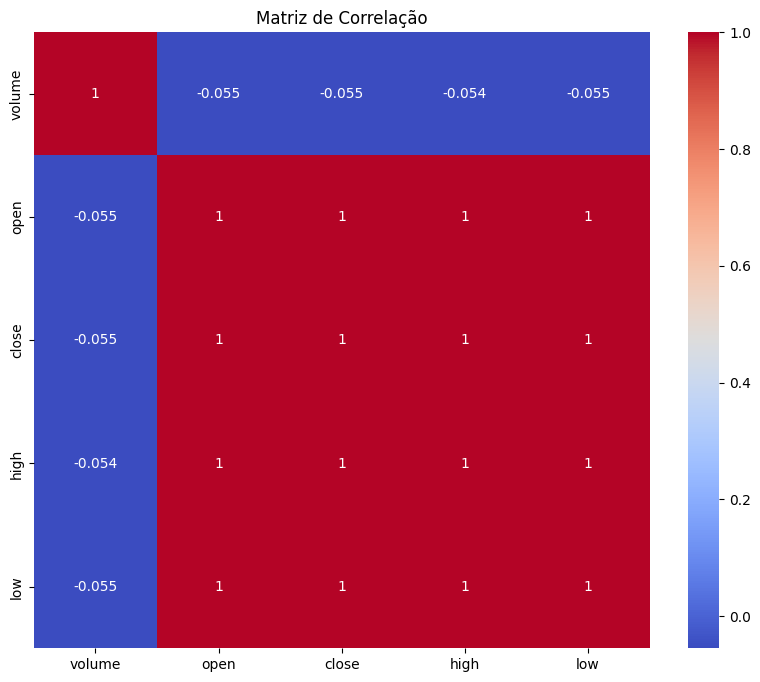

In [3]:
# Recarregar o dataset
df = load_csv_in_dataframe(
    BASE_DIR
    + '/datasets'
    + '/saida_como_preco_do_ativo_'
    + f'{coinpair.bitpreco_websocket}_{coinpair.exchange.value}'
    + '.csv',
)

# Visualizar a distribuição dos preços
plt.figure(figsize=(8, 6))
sns.lineplot(x=df.index, y=df['close'])
plt.title('Preços de Fechamento ao Longo do Tempo')
plt.show()

# Matriz de correlação entre as variáveis
corr_matrix = df[['volume', 'open', 'close', 'high', 'low']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('Matriz de Correlação')
plt.show()


2. Avaliação de Desempenho de Modelos

Treinamento e Validação de Modelos

Use um modelo de regressão para avaliar a qualidade do dataset. O objetivo é verificar se o modelo consegue aprender padrões significativos a partir das variáveis de entrada para prever o preço de fechamento deslocado.

In [ ]:
# Dividir o dataset em treino e teste
X = df[['volume', 'open', 'high', 'low']]
y = df['y']  # Preço de fechamento deslocado

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinar um modelo de regressão
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Prever os preços para o conjunto de teste
y_pred = model.predict(X_test)

# Avaliar o desempenho do modelo
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
console.print(f'Erro Quadrático Médio (MSE): {mse:.2f}')
console.print(f'Erro Absoluto Médio (MAE): {mae:.2f}')


3. Análise de Feature Importance

Avaliar a Importância das Variáveis

Verifique quais variáveis são mais importantes para a previsão do preço de fechamento deslocado.

In [ ]:
# Avaliar a importância das features
feature_importances = model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(8, 6))
sns.barplot(x=feature_names, y=feature_importances)
plt.title('Importância das Features')
plt.xlabel('Feature')
plt.ylabel('Importância')
plt.show()


In [ ]:
# Avaliar o modelo com validação cruzada
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
console.print(f'Scores de Validação Cruzada: {scores}')
console.print(f'Média dos Scores: {-scores.mean():.2f}')

4. Validação Cruzada

Avaliar o Desempenho em Diferentes Partições

Use validação cruzada para garantir que o modelo não está sobreajustado (overfitting) a uma única partição dos dados.

### Segundo dataset:
- Entradas: volume, preço de abertura, preço de fechamento, preço máximo e preço mínimo
- Saida: 5 níveis de tendência geral

    -2: Baixa forte

    -1: Tendência de baixa

    0: Tendência neutra

    1: Tendência de alta

    2: Alta forte

In [ ]:
# Carregar o arquivo CSV
df = get_price_history(coin_pair=coinpair)
df = df.copy()
# Converter Series para numpy arrays
close_arr = df['close'].to_numpy(dtype=float)
high_arr = df['high'].to_numpy(dtype=float)
low_arr = df['low'].to_numpy(dtype=float)
volume_arr = df['volume'].to_numpy(dtype=float)

##### Calcular os indicadores osciladores

In [ ]:
# Indicador Maravilhoso
def AO(df):
    """
    Awesome Oscillator
    """
    df['media'] = (df['open'] + df['close']) / 2
    df['media'] = df['media'].to_numpy(dtype=float)

    # Definir os períodos para as médias móveis
    periodo_curto = 5
    periodo_longo = 34

    # Calcular as médias móveis usando TA-Lib
    df['SMA_Curta'] = ta.SMA(df['media'].values, timeperiod=periodo_curto)
    df['SMA_Longa'] = ta.SMA(df['media'].values, timeperiod=periodo_longo)

    return df['SMA_Curta'] - df['SMA_Longa']

In [6]:
# Índice de Força Relativa (14)
df['RSI'] = ta.RSI(close_arr, timeperiod=14)
# Estocástico %K (14, 3, 3)
df['stoch_k'], df['stoch_d'] = ta.STOCH(
    high_arr,
    low_arr,
    close_arr,
    fastk_period=14,
    slowk_period=3,
    slowd_period=3,
)
# índice Canal de Commodities
df['CCI'] = ta.CCI(high_arr, low_arr, close_arr, timeperiod=20)
# Índice Direcional Médio
df['ADX'] = ta.ADX(high_arr, low_arr, close_arr, timeperiod=14)
# Oscilador Maravilhoso
df['AO'] = AO(df)
# Momentum (10)
df['MOM'] = ta.MOM(close_arr, timeperiod=10)
# Nível MACD (12,26)
df['MACD'], df['MACD_signal'], df['MACD_hist'] = ta.MACD(
    close_arr,
    fastperiod=12,
    slowperiod=26,
    signalperiod=9,
)
# IFR Estocástico Rápido (3, 3, 14, 14)
df['stoch_rsi_k'], df['stoch_rsi_d'] = ta.STOCHF(
    high=high_arr,
    low=low_arr,
    close=close_arr,
    fastk_period=14,
    fastd_period=3,
    fastd_matype=0,
)
# Range Percentual de Williams (14)
df['WILLR'] = ta.WILLR(high_arr, low_arr, close_arr, timeperiod=14)
# Bull Bear Power
df['BBP'] = ta.CDLKICKINGBYLENGTH(
    open=df['open'].to_numpy(dtype=float),
    high=high_arr,
    low=low_arr,
    close=close_arr,
)
# Ultimate Oscillator (7, 14, 28)
df['ULTOSC'] = ta.ULTOSC(
    high_arr,
    low_arr,
    close_arr,
    timeperiod1=7,
    timeperiod2=14,
    timeperiod3=28,
)

##### Calcular indicadores médias móveis

In [7]:
# Calcular a VWMA
def calcular_vwma(df, periodo):
    # Calcular a soma ponderada dos preços
    soma_ponderada = df['close'] * df['volume']

    # Calcular a soma dos volumes
    soma_volumes = df['volume']

    # Calcular a VWMA
    vwma = (
        soma_ponderada.rolling(window=periodo).sum()
        / soma_volumes.rolling(window=periodo).sum()
    )

    return vwma

In [8]:
# Calcular a Linha Base (Kijun-sen)
def calcular_kijun_sen(df):
    maximos = df['high'].rolling(window=26).max()
    minimos = df['low'].rolling(window=26).min()
    kijun_sen = (maximos + minimos) / 2
    return kijun_sen

In [9]:
# Calcular a Média Móvel de Hull
def calcular_hma(df, n):
    df['close'] = df['close'].to_numpy(dtype=float)
    wma_metade = ta.WMA(df['close'].values, timeperiod=int(n / 2))
    wma_completa = ta.WMA(df['close'].values, timeperiod=n)
    hma_intermediaria = 2 * wma_metade - wma_completa
    hma = ta.WMA(hma_intermediaria, timeperiod=int(np.sqrt(n)))
    return hma

In [10]:
# Média Movel Exponencial (10)
df['EMA10'] = ta.EMA(close_arr, timeperiod=10)
# Média Movel Simples (10)
df['SMA10'] = ta.SMA(close_arr, timeperiod=10)
# Média Movel Exponencial (20)
df['EMA20'] = ta.EMA(close_arr, timeperiod=20)
# Média Movel Simples (20)
df['SMA20'] = ta.SMA(close_arr, timeperiod=20)
# Média Movel Exponencial (30)
df['EMA30'] = ta.EMA(close_arr, timeperiod=30)
# Média Movel Simples (30)
df['SMA30'] = ta.SMA(close_arr, timeperiod=30)
# Média Movel Exponencial (50)
df['EMA50'] = ta.EMA(close_arr, timeperiod=50)
# Média Movel Simples (50)
df['SMA50'] = ta.SMA(close_arr, timeperiod=50)
# Média Movel Exponencial (100)
df['EMA100'] = ta.EMA(close_arr, timeperiod=100)
# Média Movel Simples (100)
df['SMA100'] = ta.SMA(close_arr, timeperiod=100)
# Média Movel Exponencial (200)
df['EMA200'] = ta.EMA(close_arr, timeperiod=200)
# Média Movel Simples (200)
df['SMA200'] = ta.SMA(close_arr, timeperiod=200)
# Linha Base Ichimoku (9, 26, 52, 26)
df['Kijun-sen'] = calcular_kijun_sen(df)
# Média Móvel Ponderada pelo Volume (20)
df['VWMA'] = calcular_vwma(df, 20)
# Média Móvel de Hull (9)
df['HMA'] = calcular_hma(df, 9)

##### Calcular as tendências individuais de cada indicador

In [11]:
# Função para classificar tendências em 5 níveis
def classificar_tendencia(valor, limites):
    """
    Classifica um valor em 5 níveis de tendência:
    -2: Baixa forte
    -1: Tendência de baixa
    0: Tendência neutra
    1: Tendência de alta
    2: Alta forte
    """
    forte_baixa, baixa, alta, forte_alta = limites

    if valor <= forte_baixa:
        return -2  # Baixa forte
    elif valor <= baixa:
        return -1  # Tendência de baixa
    elif valor >= forte_alta:
        return 2  # Alta forte
    elif valor >= alta:
        return 1  # Tendência de alta
    else:
        return 0  # Tendência neutra


# Classifica osciladores
# RSI (0-100)
df['tendencia_RSI'] = df['RSI'].apply(
    lambda x: classificar_tendencia(x, (30, 40, 60, 70))
)

# Estocástico %K (0-100)
df['tendencia_stoch_k'] = df['stoch_k'].apply(
    lambda x: classificar_tendencia(x, (20, 35, 65, 80))
)

# Estocástico %D (0-100)
df['tendencia_stoch_d'] = df['stoch_d'].apply(
    lambda x: classificar_tendencia(x, (20, 35, 65, 80))
)

# CCI (-100 a +100 tipicamente)
df['tendencia_CCI'] = df['CCI'].apply(
    lambda x: classificar_tendencia(x, (-200, -100, 100, 200))
)

# ADX (0-100)
df['tendencia_ADX'] = df['ADX'].apply(
    lambda x: 2 if x > 50 else (1 if x > 25 else 0)
)

# Oscilador Maravilhoso (AO)
# Criando coluna com o valor anterior para comparação
df['AO_anterior'] = df['AO'].shift(1)
df['tendencia_AO'] = df.apply(
    lambda row: 2
    if row['AO'] > 0 and row['AO'] > row['AO_anterior']
    else (
        1
        if row['AO'] > 0
        else (
            -2
            if row['AO'] < 0 and row['AO'] < row['AO_anterior']
            else (-1 if row['AO'] < 0 else 0)
        )
    ),
    axis=1,
)

# Momentum
df['tendencia_MOM'] = df.apply(
    lambda row: 2
    if row['MOM'] > 3
    else (
        1
        if row['MOM'] > 0
        else (-2 if row['MOM'] < -3 else (-1 if row['MOM'] < 0 else 0))
    ),
    axis=1,
)

# MACD
# Criando coluna com o valor anterior para comparação
df['MACD_hist_anterior'] = df['MACD_hist'].shift(1)
df['tendencia_MACD'] = df.apply(
    lambda row: 2
    if row['MACD'] > row['MACD_signal']
    and row['MACD_hist'] > row['MACD_hist_anterior']
    else (
        1
        if row['MACD'] > row['MACD_signal']
        else (
            -2
            if row['MACD'] < row['MACD_signal']
            and row['MACD_hist'] < row['MACD_hist_anterior']
            else (-1 if row['MACD'] < row['MACD_signal'] else 0)
        )
    ),
    axis=1,
)

# IFR Estocástico Rápido
df['tendencia_stoch_rsi_k'] = df['stoch_rsi_k'].apply(
    lambda x: classificar_tendencia(x, (20, 35, 65, 80))
)
df['tendencia_stoch_rsi_d'] = df['stoch_rsi_d'].apply(
    lambda x: classificar_tendencia(x, (20, 35, 65, 80))
)

# Williams %R (0 a -100)
df['tendencia_WILLR'] = df['WILLR'].apply(
    lambda x: classificar_tendencia(-x, (-80, -65, -35, -20))
)

# Bull Bear Power
df['tendencia_BBP'] = df['BBP'].apply(
    lambda x: 2
    if x > 75
    else (1 if x > 0 else (-2 if x < -75 else (-1 if x < 0 else 0)))
)

# Ultimate Oscillator (0-100)
df['tendencia_ULTOSC'] = df['ULTOSC'].apply(
    lambda x: classificar_tendencia(x, (30, 40, 60, 70))
)

# Classificar tendências de médias móveis
# Para todas as médias móveis, compara o preço atual (close) com a média
df['tendencia_EMA10'] = df.apply(
    lambda row: 2
    if row['close'] > row['EMA10'] * 1.03
    else (
        1
        if row['close'] > row['EMA10']
        else (
            -2
            if row['close'] < row['EMA10'] * 0.97
            else (-1 if row['close'] < row['EMA10'] else 0)
        )
    ),
    axis=1,
)

df['tendencia_SMA10'] = df.apply(
    lambda row: 2
    if row['close'] > row['SMA10'] * 1.03
    else (
        1
        if row['close'] > row['SMA10']
        else (
            -2
            if row['close'] < row['SMA10'] * 0.97
            else (-1 if row['close'] < row['SMA10'] else 0)
        )
    ),
    axis=1,
)

df['tendencia_EMA20'] = df.apply(
    lambda row: 2
    if row['close'] > row['EMA20'] * 1.05
    else (
        1
        if row['close'] > row['EMA20']
        else (
            -2
            if row['close'] < row['EMA20'] * 0.95
            else (-1 if row['close'] < row['EMA20'] else 0)
        )
    ),
    axis=1,
)

df['tendencia_SMA20'] = df.apply(
    lambda row: 2
    if row['close'] > row['SMA20'] * 1.05
    else (
        1
        if row['close'] > row['SMA20']
        else (
            -2
            if row['close'] < row['SMA20'] * 0.95
            else (-1 if row['close'] < row['SMA20'] else 0)
        )
    ),
    axis=1,
)

df['tendencia_EMA30'] = df.apply(
    lambda row: 2
    if row['close'] > row['EMA30'] * 1.07
    else (
        1
        if row['close'] > row['EMA30']
        else (
            -2
            if row['close'] < row['EMA30'] * 0.93
            else (-1 if row['close'] < row['EMA30'] else 0)
        )
    ),
    axis=1,
)

df['tendencia_SMA30'] = df.apply(
    lambda row: 2
    if row['close'] > row['SMA30'] * 1.07
    else (
        1
        if row['close'] > row['SMA30']
        else (
            -2
            if row['close'] < row['SMA30'] * 0.93
            else (-1 if row['close'] < row['SMA30'] else 0)
        )
    ),
    axis=1,
)

df['tendencia_EMA50'] = df.apply(
    lambda row: 2
    if row['close'] > row['EMA50'] * 1.1
    else (
        1
        if row['close'] > row['EMA50']
        else (
            -2
            if row['close'] < row['EMA50'] * 0.9
            else (-1 if row['close'] < row['EMA50'] else 0)
        )
    ),
    axis=1,
)

df['tendencia_SMA50'] = df.apply(
    lambda row: 2
    if row['close'] > row['SMA50'] * 1.1
    else (
        1
        if row['close'] > row['SMA50']
        else (
            -2
            if row['close'] < row['SMA50'] * 0.9
            else (-1 if row['close'] < row['SMA50'] else 0)
        )
    ),
    axis=1,
)

df['tendencia_EMA100'] = df.apply(
    lambda row: 2
    if row['close'] > row['EMA100'] * 1.15
    else (
        1
        if row['close'] > row['EMA100']
        else (
            -2
            if row['close'] < row['EMA100'] * 0.85
            else (-1 if row['close'] < row['EMA100'] else 0)
        )
    ),
    axis=1,
)

df['tendencia_SMA100'] = df.apply(
    lambda row: 2
    if row['close'] > row['SMA100'] * 1.15
    else (
        1
        if row['close'] > row['SMA100']
        else (
            -2
            if row['close'] < row['SMA100'] * 0.85
            else (-1 if row['close'] < row['SMA100'] else 0)
        )
    ),
    axis=1,
)

df['tendencia_EMA200'] = df.apply(
    lambda row: 2
    if row['close'] > row['EMA200'] * 1.2
    else (
        1
        if row['close'] > row['EMA200']
        else (
            -2
            if row['close'] < row['EMA200'] * 0.8
            else (-1 if row['close'] < row['EMA200'] else 0)
        )
    ),
    axis=1,
)

df['tendencia_SMA200'] = df.apply(
    lambda row: 2
    if row['close'] > row['SMA200'] * 1.2
    else (
        1
        if row['close'] > row['SMA200']
        else (
            -2
            if row['close'] < row['SMA200'] * 0.8
            else (-1 if row['close'] < row['SMA200'] else 0)
        )
    ),
    axis=1,
)

df['tendencia_Kijun'] = df.apply(
    lambda row: 2
    if row['close'] > row['Kijun-sen'] * 1.05
    else (
        1
        if row['close'] > row['Kijun-sen']
        else (
            -2
            if row['close'] < row['Kijun-sen'] * 0.95
            else (-1 if row['close'] < row['Kijun-sen'] else 0)
        )
    ),
    axis=1,
)

df['tendencia_VWMA'] = df.apply(
    lambda row: 2
    if row['close'] > row['VWMA'] * 1.05
    else (
        1
        if row['close'] > row['VWMA']
        else (
            -2
            if row['close'] < row['VWMA'] * 0.95
            else (-1 if row['close'] < row['VWMA'] else 0)
        )
    ),
    axis=1,
)

df['tendencia_HMA'] = df.apply(
    lambda row: 2
    if row['close'] > row['HMA'] * 1.03
    else (
        1
        if row['close'] > row['HMA']
        else (
            -2
            if row['close'] < row['HMA'] * 0.97
            else (-1 if row['close'] < row['HMA'] else 0)
        )
    ),
    axis=1,
)

##### Fazer a moda das tendências para a tendência geral

In [ ]:
# Selecionar todas as colunas que começam com 'tendencia_'
colunas_tendencia = [col for col in df.columns if col.startswith('tendencia_')]

console.print(f'Total de indicadores de tendência: {len(colunas_tendencia)}')
console.print(f"Indicadores utilizados: {', '.join(colunas_tendencia)}")

# classificar tendência geral vendo o que a maioria
# dos indicadores estão indicando
df['tendencia_geral'] = df[colunas_tendencia].mode(axis=1)[0]

Total de indicadores de tendência: 28
Indicadores utilizados: tendencia_RSI, tendencia_stoch_k, tendencia_stoch_d, tendencia_CCI, tendencia_ADX, tendencia_AO, tendencia_MOM, tendencia_MACD, tendencia_stoch_rsi_k, tendencia_stoch_rsi_d, tendencia_WILLR, tendencia_BBP, tendencia_ULTOSC, tendencia_EMA10, tendencia_SMA10, tendencia_EMA20, tendencia_SMA20, tendencia_EMA30, tendencia_SMA30, tendencia_EMA50, tendencia_SMA50, tendencia_EMA100, tendencia_SMA100, tendencia_EMA200, tendencia_SMA200, tendencia_Kijun, tendencia_VWMA, tendencia_HMA


##### fazer a saída que é a tendência geral deslocada para o minuto seguinte

In [14]:
df['y'] = df['tendencia_geral'].shift(-1)
# dropar as linhas que não tem o valor de y
df = df.dropna()
# Selecionar apenas as colunas volume, open, high, low, close e y
df = df[
    [
        'timestamp',
        'volume',
        'open',
        'high',
        'low',
        'close',
        'y',
    ]
]
# Salvar o dataframe em um arquivo CSV com o duckdb por que são muitos dados
save_to_csv_duckdb(
    df,
    BASE_DIR
    + '/datasets'
    + '/saida_como_tendencia_geral_'
    + f'{coinpair.bitpreco_websocket}_{coinpair.exchange.value}'
    + '.csv',
)

True

#### Validação e Avaliação do Dataset

In [ ]:
df = load_csv_in_dataframe(
    BASE_DIR
    + '/datasets'
    + '/saida_como_tendencia_geral_'
    + f'{coinpair.bitpreco_websocket}_{coinpair.exchange.value}'
    + '.csv',
)
# Visualizar a distribuição das classes de tendência
plt.figure(figsize=(8, 6))
sns.countplot(x='y', data=df)
plt.title('Distribuição das Classes de Tendência')
plt.show()

# Matriz de correlação entre as variáveis
corr_matrix = df[['volume', 'open', 'close', 'high', 'low', 'y']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('Matriz de Correlação')
plt.show()

2. Avaliação de Desempenho de Modelos

In [ ]:
# Dividir o dataset em treino e teste
X = df[['volume', 'open', 'close', 'high', 'low']]
y = df['tendencia']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinar um modelo de classificação
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Prever as classes para o conjunto de teste
y_pred = model.predict(X_test)

# Avaliar o desempenho do modelo
accuracy = accuracy_score(y_test, y_pred)
console.print(f'Acurácia: {accuracy:.3f}')
console.print('Relatório de Classificação:')
print(classification_report(y_test, y_pred))
print('Matriz de Confusão:')
print(confusion_matrix(y_test, y_pred))

3. Análise de Feature Importance

In [ ]:
# Avaliar a importância das features
feature_importances = model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(8, 6))
sns.barplot(x=feature_names, y=feature_importances)
plt.title('Importância das Features')
plt.xlabel('Feature')
plt.ylabel('Importância')
plt.show()

4. Validação Cruzada

Avaliar o Desempenho em Diferentes Partições

Use validação cruzada para garantir que o modelo não está sobreajustado (overfitting) a uma única partição dos dados.

In [ ]:
# Avaliar o modelo com validação cruzada
scores = cross_val_score(model, X_train, y_train, cv=5)
console.print(f'Scores de Validação Cruzada: {scores}')
console.print(f'Média dos Scores: {scores.mean():.3f}')

### Terceiro dataset:
- Entradas: volume, preço de abertura, preço de fechamento, preço máximo e preço mínimo
- Saida: sinal de compra(-1), venda(1) ou neutro, ou seja não comprar e nem vender (0)

In [ ]:
# Carregar os dados do db
df = get_price_history(coin_pair=coinpair)

### Geração de Sinais Determinísticos
Considerações Sobre Ajustes de Parâmetros

A eficácia dos sinais determinísticos depende significativamente da configuração dos parâmetros. Alguns aspectos cruciais a considerar:

Parâmetros Críticos

- Janela de Análise Futura: Define quanto do futuro será considerado para geração de sinais. Janelas mais curtas resultam em sinais mais frequentes, enquanto janelas mais longas capturam tendências mais sustentadas.

- Limiares de Compra e Venda: Determina a sensibilidade da geração de sinais. Valores mais baixos geram mais sinais (potencialmente mais falsos positivos), enquanto valores mais altos geram sinais apenas em movimentos significativos.

- Metas de Lucro e Stop Loss: Define quando uma operação seria considerada bem-sucedida em um ambiente real de trading, impactando os sinais gerados.

A escolha ideal destes parâmetros pode ser determinada através de backtesting sobre períodos históricos específicos, como recomendado no artigo sobre indicadores de compra e venda: "a curva de crescimento logarítmico é apresentada pelo analista como uma forma de prever o movimento do preço do Bitcoin no mercado".

In [ ]:
def generate_deterministic_signals(  # noqa: PLR0913, PLR0917
    df,
    future_window=7,
    buy_threshold=0.05,
    sell_threshold=0.05,
    profit_target=0.1,
    stop_loss=0.05,
):
    # Criar colunas para sinais
    df['buy_signal'] = 0
    df['sell_signal'] = 0

    # Para cada dia no dataset
    for i in range(len(df) - future_window):
        current_price = df.iloc[i]['close']
        future_window_data = df.iloc[i + 1 : i + future_window + 1]
        future_max = future_window_data['high'].max()
        future_min = future_window_data['low'].min()

        # Condição de compra: preço atual X% abaixo do máximo futuro
        potential_gain = (
            float(future_max) - float(current_price)
        ) / current_price
        if potential_gain > buy_threshold:
            # Verificar se o preço atingiria o profit_target antes do stop_loss
            for j in range(i + 1, i + future_window + 1):
                if df.iloc[j]['high'] >= current_price * (1 + profit_target):
                    df.at[df.index[i], 'buy_signal'] = 1
                    break
                if df.iloc[j]['low'] <= current_price * (1 - stop_loss):
                    break

        # Condição de venda: preço atual X% acima do mínimo futuro
        potential_drop = (
            float(current_price) - float(future_min)
        ) / current_price
        if potential_drop > sell_threshold:
            # Verificar se o preço cairia sell_threshold antes de subir novamente
            for j in range(i + 1, i + future_window + 1):
                if df.iloc[j]['low'] <= current_price * (1 - profit_target):
                    df.at[df.index[i], 'sell_signal'] = 1
                    break
                if df.iloc[j]['high'] >= current_price * (1 + stop_loss):
                    break

    return df

In [ ]:
# Gerar sinais determinísticos
df = generate_deterministic_signals(df)

TypeError: unsupported operand type(s) for -: 'float' and 'decimal.Decimal'

In [ ]:
df = df.dropna()
save_to_csv_duckdb(
    df,
    BASE_DIR
    + '/datasets'
    + '/saida_como_preco_do_ativo_'
    + f'{coinpair.bitpreco_websocket}_{coinpair.exchange.value}'
    + '.csv',
)

# Validação e Avaliação do Dataset
Métricas de Avaliação

- Taxa de Acerto: Porcentagem de sinais que resultariam em operações lucrativas se seguidos.

- Retorno por Operação: Lucro médio que cada sinal de compra/venda geraria.

- Máximo Drawdown: Máxima perda entre pico e vale que a estratégia poderia gerar.

- Sharpe Ratio: Relação retorno/risco dos sinais gerados.

In [ ]:
class DeterministicSignals(Strategy):
    def init(self):
        super().init()
        self.buy_signal = self.data.buy_signal
        self.sell_signal = self.data.sell_signal

    def next(self):
        current_index = len(self.data) - 1

        # Execução de ordens baseada nos sinais
        if self.buy_signal[current_index] == 1 and not self.position:
            self.buy(
                size=0.1
            )  # Altere o tamanho da posição conforme necessário

        if self.sell_signal[current_index] == 1 and self.position:
            self.position.close()

In [ ]:
bt = Backtest(
    df,
    DeterministicSignals,
    cash=10000,  # Capital inicial
    commission=.002,  # Taxa de corretagem (0.2%)
    exclusive_orders=True
)


In [ ]:
stats = bt.run()
console.print(stats)

#### Visualização de Resultados
Análise Gráfica

Este gráfico interativo mostrará:

Evolução do preço com marcadores de entradas/saídas

Curva de equity (crescimento do capital)

Drawdown máximo histórico

Distribuição temporal das operações

In [ ]:
bt.plot()

#### Validação Cruzada
Para evitar overfitting, executei a validação walk-forward:

In [ ]:
results = bt.optimize(
    maximize='Sharpe Ratio',
    method='walk_forward',
    train_size=0.7,  # 70% dados para treino
    test_size=0.3,   # 30% para teste
    fixed={'commission': 0.002}
)